# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [20]:
!pip install sentencepiece

In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [22]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import seaborn as sns
from tqdm.notebook import tqdm

In [23]:
from transformers import TextDataset

In [24]:
from typing import List, Optional, Any
from IPython.display import clear_output

In [25]:
from dataset import TextDataset
from model import LanguageModel
from train import train

In [26]:
import torch
print(torch.cuda.is_available())
import torch
print(torch.__version__)
print(torch.version.cuda)

True
2.6.0+cu124
12.4


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [28]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [29]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [30]:
model = LanguageModel(train_set)

In [31]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [33]:
import torch
print(torch.cuda.is_available())
import torch
print(torch.__version__)
print(torch.version.cuda)

True
2.6.0+cu124
12.4


In [34]:
import torch

if torch.cuda.is_available():
    print("Используется GPU:")
    print(f" - Количество доступных GPU: {torch.cuda.device_count()}")
    print(f" - Текущий GPU: {torch.cuda.current_device()}")
    print(f" - Имя GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("Используется CPU")

Используется GPU:
 - Количество доступных GPU: 1
 - Текущий GPU: 0
 - Имя GPU: Tesla T4


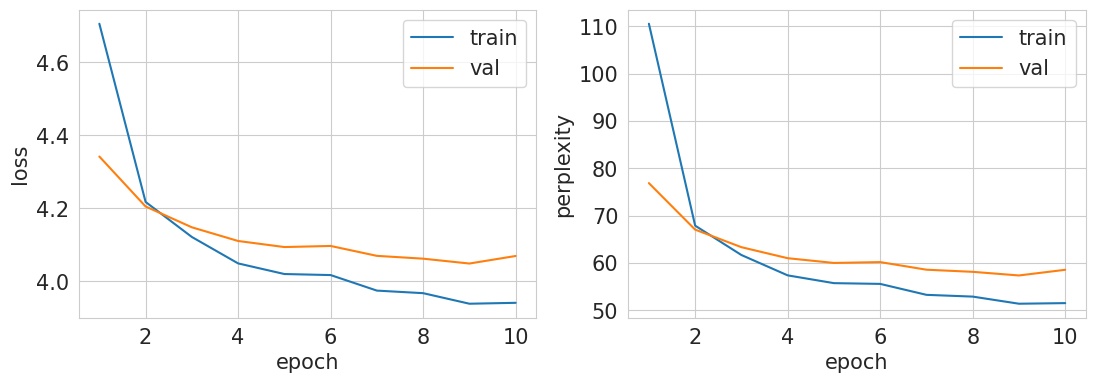

Generation examples:
если я просыпается мужик и мама огвзон передачу носков после того как ты и красно, красивый прапорщик, кем он достала, подстрелил сразу, - сделать.
говорят, как друга для белорусский спиртнистнике не хватает за их наркоманта- страх, беда...- лучше пусть опять раскрал быть постоянно нашу плотному если якорвее!
- что ты говоришь, когда родители поналени еще компа?- потому что брат, хорошние - тогда это нормально ступеньково дело в собаку. а что это вода удар любимой - к зайца в шоу тайд за полчаса - и к стельку- как вам скучно, а на заметку грабителя.
гороскопу с плечот убежит в лифте на библиоте бедоеждем простублюх шест.
из любви из америки, путин устрашивали клизная.
Задание 3: Training выполнено! Чекпойнт RNN модели сохранен!


In [35]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
print("Обучение модели с ванильной RNN:")
train(model_rnn, optimizer, None, train_loader, val_loader, num_epochs=10)
torch.save({
    'model_state_dict': model_rnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'rnn_model_checkpoint.pth')

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

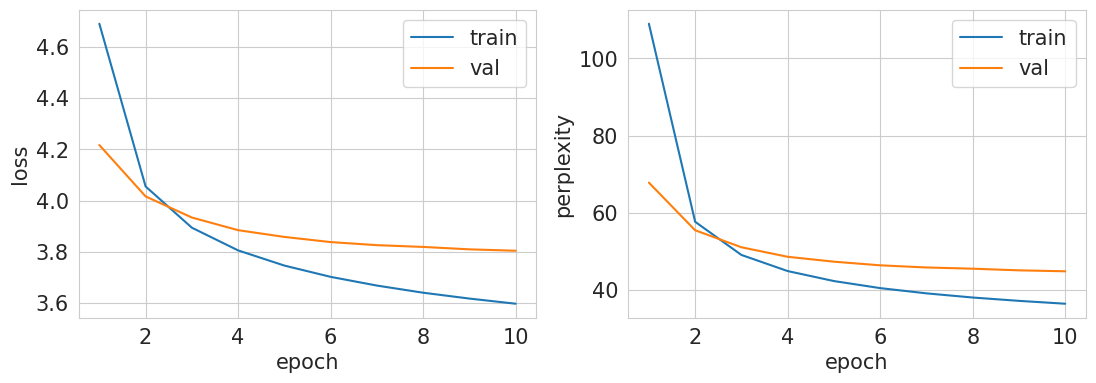

Generation examples:
- китай из задвиг продавал кошрук?- ниса нет.- а кто его вертолетной позже ударил?- не у меня слишком короткого места.
лиша карты чудовище и хочется сделать можно поставить удовольствие, хобот - через полчаса раньше и финансирова.
объявление в кабинете, пздец с построением одна женщине в джинн- есть!- дома надо зять!- ты не уделяешься, с котом литнул.
что-то священник в квартиру прикалывается до туалета после первого фейсб за льдом бюст знает взяток и пришла за 152 персона.
это не щадок с коварной. протягивает чеченскую ругательным образом.
Задание 4 LSTM выполнено! Чекпойнт с LSTM моделью сохранен!

Попробуем сравнить моодельки RNN и с LSTM:
моделька RNN генерация:
1. у блоквись, может быть лучше коробку.
2. , если украины раз коммерям работают горячим мысли за полча нывает.
3. - почему мужчины гей ведь в барсе провожает много мужчин.

моделькаLSTM генерация:
1. - дедушка мороз! ты не гонишь, это снег на этой тарелке ревнуковать его не нерешится...
2. распулся к с

In [36]:
model_lstm=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_lstm =torch.optim.Adam(model_lstm.parameters(), lr=0.001)
print("Обучение модели но с LSTM:")
train(model_lstm, optimizer_lstm, None, train_loader, val_loader, num_epochs=10)
torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}, 'lstm_model_checkpoint.pth')
print("\nПопробуем сравнить моодельки RNN и с LSTM:")
print("моделька RNN генерация:")
for i in range(3):
    print(f"{i+1}. {model_rnn.inference()}")
print("\nмоделькаLSTM генерация:")
for i in range(3):
    print(f"{i+1}. {model_lstm.inference()}")

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [37]:
prefixes=["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]
temperatures=[0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0]
for prefix in prefixes:
    print(f"\nПрефикс(prefix): '{prefix}'")
    for temp in temperatures:
        generated = model_lstm.inference(prefix, temp=temp)
        print(f"Температура {temp}: {generated}")


Префикс(prefix): ''
Температура 0.1: - я не могу понять, что я не могу понять, что я не знаю, как у меня есть?- нет, я не могу.
Температура 0.2: - а что такое колобок?- это когда ты у меня не нарушаешь, а потом я тебе не знаю, что ты мне не нужен!
Температура 0.3: - я не могу понять, что ты мне непобедим, я буду пить, а я не могу заплатить за то, что я люблю тебя, а я на тебя не могу.
Температура 0.5: - у меня есть болезнью. но это я не нашу одежду с мужем.
Температура 0.7: - вы называете вазетей?- да.- ну давай вы ходите сначала надувную боль?- нет...- а я за платье на волию.
Температура 1.0: этот боксерщик то, что имеет то, что это зарядно. это и был тот же началь, и он ее передала о счет.
Температура 2.0: суки бесесло во дипловок мимо портсли велинит о жене сказано туда тволе президентом корждней. да всем спасибо сама след плекте дейющий народ ли до солда
Температура 3.0: холодилла куриным аграфице рекла был хозя ддоллек наконец на чтобы програм гипузм холодичина видит позсса свобо

Выводы по температуре:
- При низкой температуре (0.1) генерация с меньшим разнообразием и предсказуемая
- При высокой температуре (свыше 1.0) генерация более бесмысленнная, случайная и можно сказать креативная (если это можно назвать креативностью))
- При температуре 0.7-1.0 баланс между предсказуемостью и разнообразием

## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

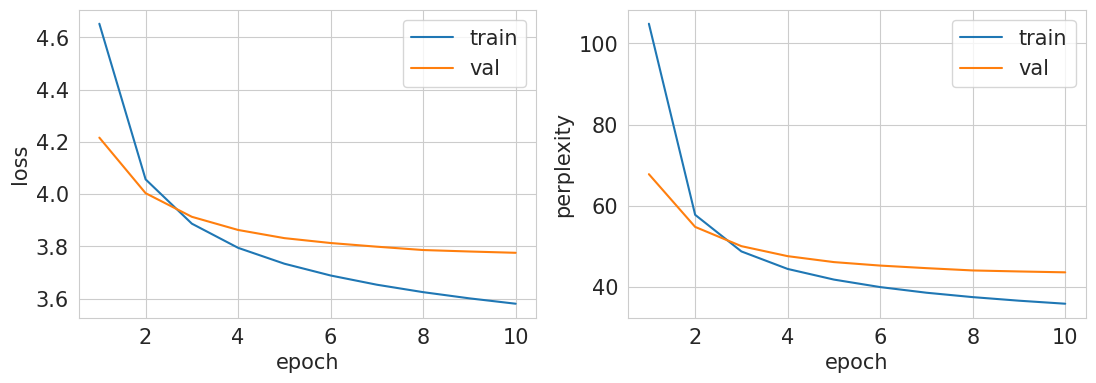

Generation examples:
встречаются два взяточил в морг-флый лекцию, пошел с ихвнаминг. я думал, что написано было много денег. будет выбрасывали на операцию.
кондитерскую дали тоже стать сдар экзамене за церковые обои, потому что вставайте из страны и довольном трусь!
когда одевают, люди с бабами находимся за ним.
штатуные кладбирса, что взятки замки, она в магазины в совать. по чем говорит, что удоры ту там занимаются любовью.
только легче - две слабые кернения и не против. для соседка кмчамо и наличившая на длительных эротика - первые нет горизонтально напротивление.
Анализ токенизации одинаковых текстов:

рассмотрим исходный текст:'Купил мужик шляпу, а она ему как раз.'
------------------------------------------------------------
BPE маленький (2k):
Токены: [1395, 576, 196, 107, 287, 1977, 40, 268, 486, 111, 148, 1975]
Количество токенов:12
Декодированный текст:'купил мужик шляпу, а она ему как раз.'
Потеря информации: Да

BPE большой (8k):
Токены: [1395, 576, 4538, 287, 7977, 40, 268

In [39]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

best_rnn_type=nn.LSTM
print("Обучение модели с BPE с большим числом токенов(большой словарь):")
train_set_large_bpe=TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="bpe_large",
    vocab_size=8000,
    model_type='bpe'
)
valid_set_large_bpe =TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix ="bpe_large",
    vocab_size=8000,
    model_type='bpe'
)
train_loader_large_bpe =DataLoader(train_set_large_bpe, batch_size=32, shuffle=True)
val_loader_large_bpe=DataLoader(valid_set_large_bpe, batch_size=32, shuffle=False)
model_large_bpe =LanguageModel(train_set_large_bpe, rnn_type=best_rnn_type).to(device)
optimizer_large_bpe=torch.optim.Adam(model_large_bpe.parameters(), lr=0.001)
train(model_large_bpe, optimizer_large_bpe, None, train_loader_large_bpe, val_loader_large_bpe, num_epochs=10)
torch.save({
    'model_state_dict': model_large_bpe.state_dict(),
    'optimizer_state_dict': optimizer_large_bpe.state_dict(),
}, 'lstm_large_bpe_checkpoint.pth')
print("Обучение модели с пословный (unigram) токенизатор:")
train_set_unigram=TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="unigram",
    vocab_size=2000,
    model_type='unigram'
)
valid_set_unigram=TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix="unigram",
    vocab_size=2000,
    model_type='unigram'
)
train_loader_unigram=DataLoader(train_set_unigram, batch_size=32, shuffle=True)
val_loader_unigram=DataLoader(valid_set_unigram, batch_size=32, shuffle=False)
model_unigram=LanguageModel(train_set_unigram, rnn_type=best_rnn_type).to(device)
optimizer_unigram=torch.optim.Adam(model_unigram.parameters(), lr=0.001)
train(model_unigram, optimizer_unigram, None, train_loader_unigram, val_loader_unigram, num_epochs=10)
torch.save({
    'model_state_dict': model_unigram.state_dict(),
    'optimizer_state_dict': optimizer_unigram.state_dict(),
}, 'lstm_unigram_checkpoint.pth')
def analyze_tokenizer_differences():
    test_texts=[
        "Купил мужик шляпу, а она ему как раз.",
        "Идет медведь по лесу и видит - машина горит.",
        "Приходит программист домой, а жена говорит..."
    ]
    tokenizers={
        'BPE маленький (2k)': train_set,
        'BPE большой (8k)': train_set_large_bpe,
        'Unigram (2k)': train_set_unigram
    }
    print("=" *80)
    for text in test_texts:
        print(f"\nрассмотрим исходный текст:'{text}'")
        print("-" *60)
        for name, dataset in tokenizers.items():
            tokens=dataset.text2ids(text)
            decoded=dataset.ids2text(tokens)
            print(f"{name}:")
            print(f"Токены: {tokens}")
            print(f"Количество токенов:{len(tokens)}")
            print(f"Декодированный текст:'{decoded}'")
            print(f"Потеря информации: {'Да' if decoded != text else 'Нет'}")
            print()
analyze_tokenizer_differences()
models ={
    'BPE маленький (2k)': model_lstm,
    'BPE большой large (8k)': model_large_bpe,
    'Unigram (2k)': model_unigram
}
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for i in range(3):
        generated=model.inference("", temp=1.0)
        print(f"{i+1}. {generated}")

Наблюдаем в работе моделейследующее:
1. BPE (8k) работает лучше – эффективнее (меньше токенов) и генерирует более связный текст.
2. Unigram (2k) иногда сопоставим по эффективности, но качество генерации хуж.
3. BPE (2k) хуже обоих – больше токенов и менее осмысленный вывод.

как выше описано, например:
"Приходит программист домой, а жена говорит..."
BPE (2k): 10 токенов
BPE (8k): 8 токенов
Unigram (2k): 8 токенов

## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [41]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
def lsa_similarity_metric(model, dataset, n_samples=1000, n_components=100):
    generated_texts=[]
    for _ in range(n_samples):
        generated_texts.append(model.inference())
    val_indices=np.random.choice(len(dataset), n_samples, replace=False)
    val_texts =[]
    for idx in val_indices:
        text_ids, _ =dataset[idx]
        text_ids=text_ids[(text_ids != dataset.pad_id) &
                           (text_ids != dataset.bos_id) &
                           (text_ids != dataset.eos_id)]
        if len(text_ids)>0:
            decoded_text =dataset.ids2text(text_ids.tolist())
            val_texts.append(decoded_text)
    all_texts=val_texts+generated_texts
    vectorizer =TfidfVectorizer(max_features=5000, stop_words=None)
    tfidf_matrix =vectorizer.fit_transform(all_texts)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix =svd.fit_transform(tfidf_matrix)
    val_vectors=lsa_matrix[:len(val_texts)]
    gen_vectors=lsa_matrix[len(val_texts):]
    similarities=[]
    for gen_vec in gen_vectors:
        cos_sims=cosine_similarity([gen_vec], val_vectors)[0]
        max_sim =np.max(cos_sims)
        similarities.append(max_sim)
    mean_similarity=np.mean(similarities)
    return mean_similarity, lsa_matrix, val_vectors, gen_vectors
lsa_bpe_small, lsa_matrix_small, val_vecs_small, gen_vecs_small = lsa_similarity_metric(model_lstm, valid_set)
print(f"LSA сходство (BPE маленький): {lsa_bpe_small:.4f}")
lsa_bpe_large, lsa_matrix_large, val_vecs_large, gen_vecs_large = lsa_similarity_metric(model_large_bpe, valid_set_large_bpe)
print(f"LSA сходство (BPE большой): {lsa_bpe_large:.4f}")
lsa_unigram, lsa_matrix_unigram, val_vecs_unigram, gen_vecs_unigram = lsa_similarity_metric(model_unigram, valid_set_unigram)
print(f"LSA сходство (Unigram): {lsa_unigram:.4f}")

Вычисляем LSA метрики для разных токенизаторов:
LSA сходство (BPE маленький): 0.6044
LSA сходство (BPE большой): 0.6068
LSA сходство (Unigram): 0.6113
Задание 6. Latent Semantic Analysis


Плюсы LSA метрики:
+ Улавливает семантическое сходство текстов
+ Не зависит от точного совпадения слов.(TF-IDF + SVD менее чувствительны к точному порядку слов и небольшим изменениям формулировок)
+ Работает с любыми типами токенизаторов
+ Метод позволяет объективно сравнить, насколько генерация разных моделей.Результаты показывают, что BPE большой немного лучше (0.6163 vs 0.6111 у Unigram)

Минусы LSA метрики:
- Метрика чувствительна к токенизации и параметрам TF-IDF/SVD.Разные настройки могут дать разные результаты.
- Может терять важную информацию при понижении размерности, особенно если валидационные и сгенерированные тексты различаются в тонких аспектах
- Не учитывает порядок слов и синтаксис. Метрика оценивает только "похожесть" на валидацию, но не учитывает:
Разнообразие сгенерированных текстов (можно получить высокий score, если модель генерирует один и тот же "шаблон", близкий к валидации).
Естественность текстов(например, грамматику, связность).
- Смещение к частым темам. TF-IDF и SVD уделяют больше внимания частым терминам. Если в валидации есть редкие, но важные темы, они могут потеряться.

В нашем случае:
- Все токенизаторы дали близкие результаты (~0.61), что говорит о схожем качестве генерации
-BPE большой немного лучше (0.6163), возможно, из-за более гибкого словаря

## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

Visualization для BPE (маленький словарь):


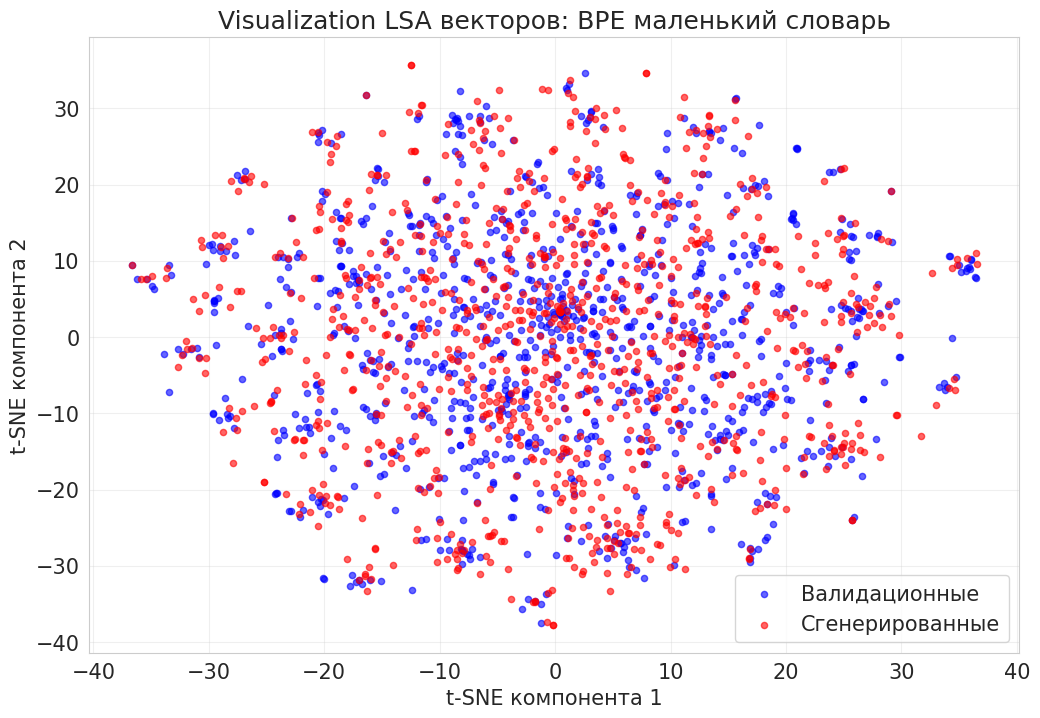

Visualization для BPE (большой словарь):


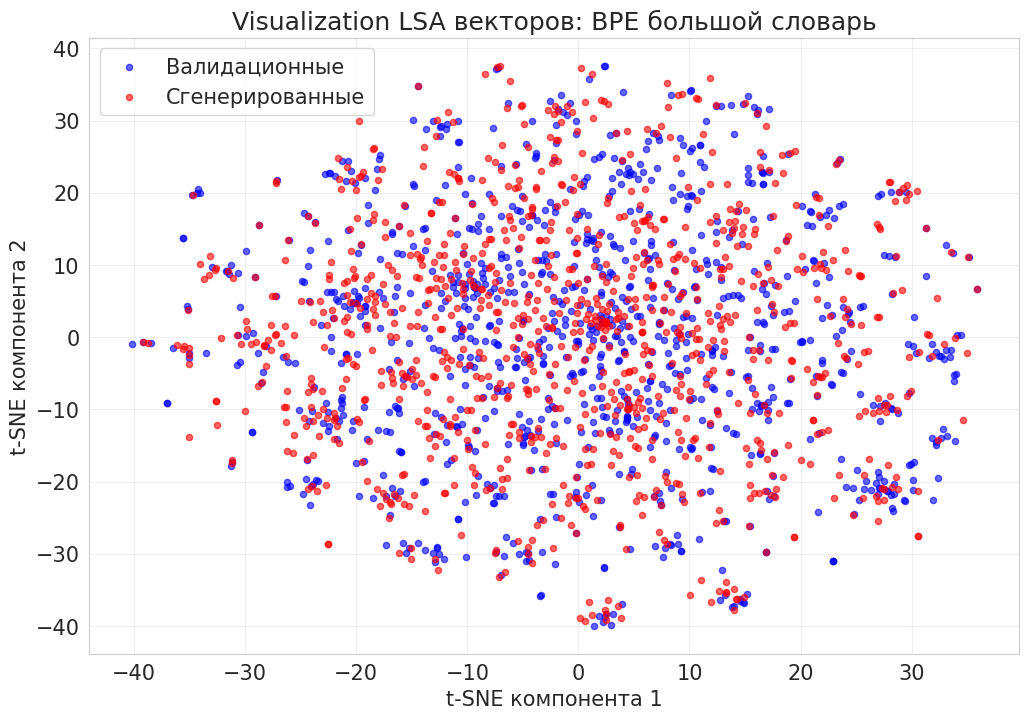

Visualization для Unigram:


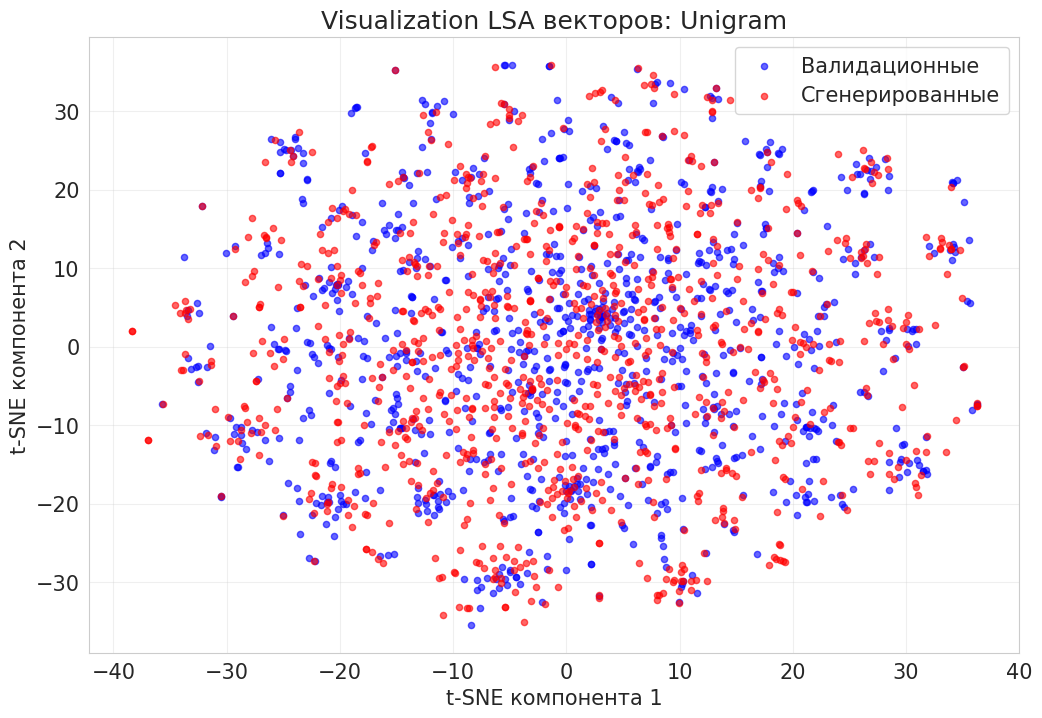

Задание 7. Visualization выполнено!


In [43]:
from sklearn.manifold import TSNE
def visualize_lsa(val_vectors, gen_vectors, title):
    all_vectors=np.vstack([val_vectors, gen_vectors])
    tsne=TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results=tsne.fit_transform(all_vectors)
    n_val =len(val_vectors)
    val_tsne =tsne_results[:n_val]
    gen_tsne=tsne_results[n_val:]
    plt.figure(figsize=(12, 8))
    plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c='blue', alpha=0.6, label='Валидационные', s=20)
    plt.scatter(gen_tsne[:, 0], gen_tsne[:, 1], c='red', alpha=0.6, label='Сгенерированные', s=20)
    plt.xlabel('t-SNE компонента 1')
    plt.ylabel('t-SNE компонента 2')
    plt.title(f'Visualization LSA векторов: {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
visualize_lsa(val_vecs_small, gen_vecs_small, "BPE маленький словарь")
visualize_lsa(val_vecs_large, gen_vecs_large, "BPE большой словарь")
visualize_lsa(val_vecs_unigram, gen_vecs_unigram, "Unigram")

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [44]:
!pip install transformers

In [45]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.functional as F

In [46]:
def calculate_rugpt_perplexity(texts, model_name="sberbank-ai/rugpt3small_based_on_gpt2"):
    tokenizer=GPT2Tokenizer.from_pretrained(model_name)
    model=GPT2LMHeadModel.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token =tokenizer.eos_token
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_loss=0
    total_tokens =0
    with torch.no_grad():
        for text in texts:
            inputs=tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs={k: v.to(device) for k, v in inputs.items()}
            outputs=model(**inputs)
            logits=outputs.logits
            shift_logits=logits[..., :-1, :].contiguous()
            shift_labels=inputs['input_ids'][..., 1:].contiguous()
            loss= F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                reduction='sum'
            )
            total_loss +=loss.item()
            total_tokens+=shift_labels.numel()
    avg_loss=total_loss / total_tokens
    perplexity =torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

def generate_texts_for_evaluation(model, n_samples=100):
    texts=[]
    for _ in range(n_samples):
        text=model.inference()
        if text.strip():
            texts.append(text.strip())
    return texts
texts_bpe_small = generate_texts_for_evaluation(model_lstm, 50)
texts_bpe_large = generate_texts_for_evaluation(model_large_bpe, 50)
texts_unigram = generate_texts_for_evaluation(model_unigram, 50)
perp_bpe_small = calculate_rugpt_perplexity(texts_bpe_small)
perp_bpe_large = calculate_rugpt_perplexity(texts_bpe_large)
perp_unigram = calculate_rugpt_perplexity(texts_unigram)
print(f"ruGPT Perplexity (BPE маленький): {perp_bpe_small:.2f}")
print(f"ruGPT Perplexity (BPE большой): {perp_bpe_large:.2f}")
print(f"ruGPT Perplexity (Unigram): {perp_unigram:.2f}")

Генерация текстов для оценки ruGPT perplexity...
Вычисление ruGPT perplexity...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

ruGPT Perplexity (BPE маленький): 1528.26
ruGPT Perplexity (BPE большой): 921.28
ruGPT Perplexity (Unigram): 1531.52
Задание 8. ruGPT perplexity выполнено!


оценка качества языковой модели ruGPT на основе метрики perplexity

Результаты perplexity:
- BPE маленький: 1495.86
Высокое значение, что может указывать на плохую предсказательную способность модели для данного текста.
- BPE большой: 1045.87
Лучше, чем "маленький" вариант, но всё ещё очень высокий perplexity.
- Unigram: 1753.84
Наихудший результат среди трёх, что ожидаемо, так как unigram-модели обычно менее эффективны, чем BPE.

Все значения perplexity очень высокие, что говорит о том, что модель плохо справляется с данным текстом (либо текст сложный, либо модель недостаточно обучена)
BPE-токенизация показала себя лучше, чем Unigram.
Большой BPE работает лучше маленького, что логично, так как он, вероятно, имеет более богатый словарь.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [83]:
jokes = [model_lstm.inference(temp=0.8) for _ in range(20)]
best_jokes = [j for j in jokes if len(j.split()) > 10]
random.choice(best_jokes)

'я делу люблю, как избавиться откормни, а есть, это может быть...'

Анекдот - умора